In [2]:
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (15, 10)

In [3]:
chain = pd.read_csv("option_chain.csv")

In [4]:
def calc_values(chain):
    underlying_price = 4184.71
    dte = 5
    risk_free_rate = 0.0006
    atm_contract_index = (np.abs(chain["strike"] - 4106.62)).idxmin()
    atm_impliedvol = chain.iloc[atm_contract_index]["impvol"]

    # Calculate option value for all options using ATM volatility
    chain["values"] = chain.apply(
        lambda x: bs_price(
            x["right"],
            x["underprice"],
            x["strike"],
            dte / 252,
            atm_impliedvol,
            risk_free_rate,
        ),
        axis=1,
    )
    chain["mid_price"] = (chain["bid"] + chain["ask"]) / 2
    chain["skew_premium"] = chain["mid_price"] - chain["values"]

    return chain

In [5]:
def bs_price(right, S, K, T, sigma, r):
    """
    Return's option price via Black-Scholes
    
    right: "P" or "C"
    S: Underlying price
    K: Strike price
    T: time to expiration (in days)
    sigma: volatility of the underlying
    r: interest rate (in daily terms)
    """
    d1 = (1 / (sigma * np.sqrt(T))) * (np.log(S / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)
    
    if right == "C":
        price = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * T)
        return price
    
    if right == "P":
        price = norm.cdf(-d2) * K * np.exp(-r * T) - norm.cdf(-d1) * S
        return price

In [18]:
underlying_price = 4184.71
dte = 5
risk_free_rate = .0006
atm_contract_index = (np.abs(chain["strike"] - underlying_price)).idxmin()
atm_impliedvol = chain.iloc[atm_contract_index]["impvol"]

# Calculate option value for all options using ATM volatility
chain["values"] = chain.apply(lambda x: bs_price(x["right"], underlying_price, x["strike"], dte / 252,
                                                 atm_impliedvol, risk_free_rate), axis=1)
chain["mid_price"] = (chain["bid"] + chain["ask"]) / 2
chain["skew_premium"] = chain["mid_price"] - chain["values"]

<AxesSubplot:>

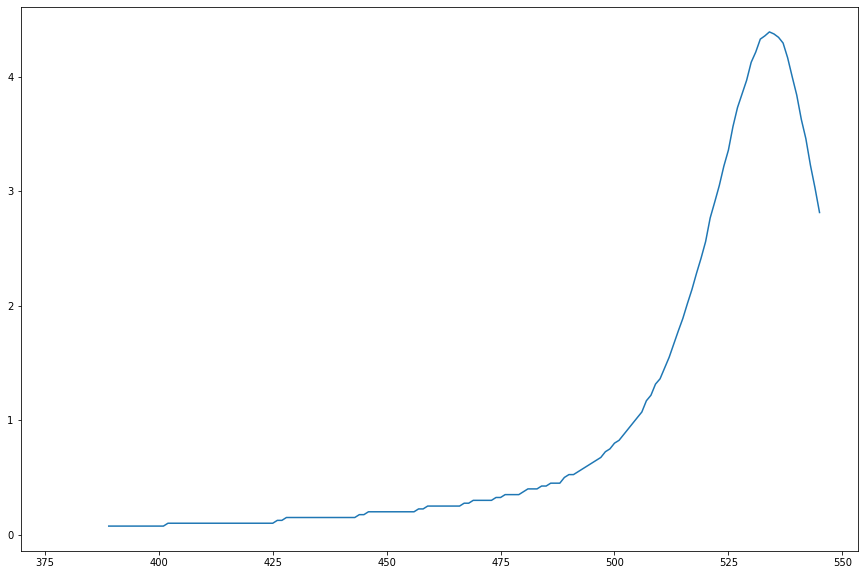

In [23]:
chain[(chain["right"] == "P") & (chain["strike"] < underlying_price)]["skew_premium"].plot()

In [24]:
put_contract = chain[(chain["right"] == "P") & (chain["strike"] < underlying_price)]["skew_premium"].idxmax()
put_contract = chain.iloc[put_contract]
# Buy put option so our margin required is $1000
put_contract_hedge = chain[(chain["strike"] == (put_contract["strike"] - 10)) & (chain["right"] == "P")].squeeze()

# Find the corresponding call option to make the position delta neutral
put_contract_delta = put_contract["delta"]
call_contract = np.abs(chain[chain["right"] == "C"]["delta"] + put_contract_delta).idxmin()
call_contract = chain[chain["right"] == "C"].iloc[call_contract]
# Find respective call hedge option
call_contract_hedge = chain[(chain["strike"] == (call_contract["strike"] + 10)) & (chain["right"] == "C")].squeeze()

In [25]:
put_contract

strike            4125.0
right                  P
bid                  8.8
ask                  9.1
impvol           0.12066
delta          -0.155062
modelprice      4.816011
gamma           0.004033
vega              1.1675
theta          -1.406372
underprice       4184.71
values          4.556736
mid_price           8.95
skew_premium    4.393264
Name: 534, dtype: object

In [7]:
class ShortIronCondor():
    def __init__(self, put, call, hedge_put, hedge_call):
        self.put = put
        self.call = call
        self.hedge_put = hedge_put
        self.hedge_call = hedge_call
        self.premium = (call["mid_price"] + put["mid_price"]) - (hedge_put["mid_price"] + hedge_call["mid_price"])
        self.max_loss = put["strike"] - hedge_put["strike"] - self.premium
        
    def pnl(self, underlying_price):
        if self.call["strike"] > underlying_price > self.put["strike"]:
            pnl = self.premium
        elif underlying_price < self.put["strike"]:
            pnl = max((underlying_price - self.put["strike"]) + self.premium, -self.max_loss)
        elif underlying_price > self.call["strike"]:
            pnl = max((self.call["strike"] - underlying_price) + self.premium, -self.max_loss)
        return pnl

In [162]:
vols = norm.rvs(.10, .01, 10000)
returns = norm.rvs(0, vols / np.sqrt(52))
prices = underlying_price * (1 + returns)

position = ShortIronCondor(put_contract, call_contract, put_contract_hedge, call_contract_hedge)
vfunc = np.vectorize(position.pnl)
pnl = vfunc(prices) / 10

In [165]:
def log_wealth(f, returns):
    return -np.mean(np.log(1 + f * returns))

In [166]:
initial = np.random.rand()

result = minimize(log_wealth, initial, (pnl))

In [167]:
result

      fun: -0.020283284832133645
 hess_inv: array([[3.88433059]])
      jac: array([-3.22936103e-07])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([0.41977911])

In [181]:
results = []

for x in range(100):
    vols = norm.rvs(.10, .01, 100000)
    returns = norm.rvs(0, vols / np.sqrt(52))
    prices = underlying_price * (1 + returns)

    position = ShortIronCondor(put_contract, call_contract, put_contract_hedge, call_contract_hedge)
    vfunc = np.vectorize(position.pnl)
    pnl = vfunc(prices) / 10
    
    initial = np.random.rand()

    result = minimize(log_wealth, initial, (pnl))
    results.append(result.x)